In [3]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 31.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 38.5 MB/s eta 0:00:00a 0:00:01


In [7]:
!pip install seaborn

In [5]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 28.9 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

### PART 1 

#### -------- Load and prepare the dataset --------

In [3]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
column_names = ['ID', 'Diagnosis'] + [f'Feature_{i}' for i in range(1, 31)]
data = pd.read_csv(url, header=None, names=column_names)

# diagnosis ----> (M = 1, B = 0)
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})
data = data.drop('ID', axis=1)

X = data.drop('Diagnosis', axis=1).values
y = data['Diagnosis'].values
    
X.shape, y.shape


((569, 30), (569,))

#### -------- Develop custom distance functions ---------

In [24]:
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))


#### -------- KNN classifier --------

In [25]:
def knn_predict(X_train, y_train, X_test, k):
    y_pred = []
    
    for test_point in X_test:
        distances = []
        
        # distances hesapla
        for i in range(len(X_train)):
            dist = manhattan_distance(test_point, X_train[i])
            distances.append((dist, y_train[i]))
        
        distances.sort(key=lambda x: x[0]) # distances touple dizisini her touple'ın 0. elemanına göre sırala.
        k_nearest = distances[:k]
        
        # yakınlık hesaplaması sonucu oluşanın etiketlerini al. 
        k_nearest_labels = []
        for pair in k_nearest:
            label = pair[1]     
            k_nearest_labels.append(label)
        
        # Final - her etiketin kaç tane olduğunu sayıp en çok olanları seç.
        majority_vote = max(set(k_nearest_labels), key=k_nearest_labels.count)
        
        y_pred.append(majority_vote) # bu x e ait tahmini listeye ekle. 
    
    return np.array(y_pred)

#### k-fold cross-validation

In [26]:
def k_fold_cross_validation(X, y, k_neighbors, n_folds=3):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    conf_matrices = []
    run_times = []
    fold_results = []

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # verileri scale et. bazı değerler küçük bazı büyük. standardize et. 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    fold_num = 1
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # KNN Çalıştır 
        start_time = time.time()
        y_pred = knn_predict(X_train, y_train, X_test, k_neighbors)
        end_time = time.time()
        run_time = end_time - start_time
        
        # Performans hesapla
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # performansları listelerine ekle
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        conf_matrices.append(conf_matrix)
        run_times.append(run_time)
        
        # tümünü fold result listesinde topla
        fold_results.append({
            'fold': fold_num,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'conf_matrix': conf_matrix,
            'run_time': run_time
        })
        
        fold_num += 1
    
    return {
        'accuracy': np.mean(accuracy_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f1': np.mean(f1_scores),
        'conf_matrices': conf_matrices,
        'run_time': np.mean(run_times),
        'fold_results': fold_results
    }


#### Create a function to plot confusion matrix

In [27]:
def plot_confusion_matrix(conf_matrices, title):
    avg_conf_matrix = np.mean(conf_matrices, axis=0)
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['True (0)', 'False (1)'],
                yticklabels=['True (0)', 'False (1)'])
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {title}')
    # plt.tight_layout()
    plt.show()


#### Run all functions

In [28]:

print("KNN Code starts here")
k = 3

# Çalıştır 
overall_start_time = time.time()
results = k_fold_cross_validation(X, y, k)
overall_end_time = time.time()
overall_run_time = overall_end_time - overall_start_time

print("KNN Code ok. ")


KNN Code starts here
KNN Code ok. 


#### Sonuçlar;


 --- Results by Fold:
----------------------------------------------------------------------------------------------------
Fold   Accuracy   Precision  Recall     F1 Score   Run Time  
----------------------------------------------------------------------------------------------------
1      0.9632 0.9420 0.9559 0.9489 0.1661s
2      0.9579 0.9545 0.9265 0.9403 0.1489s
3      0.9683 1.0000 0.9211 0.9589 0.1432s

--- Results Summary:
--------------------------------------------------
Configuration: k=3
Average Accuracy: 0.9631
Average Precision: 0.9655
Average Recall: 0.9345
Average F1 Score: 0.9494
Average Fold Run Time: 0.1527s
Total Run Time: 0.4683s


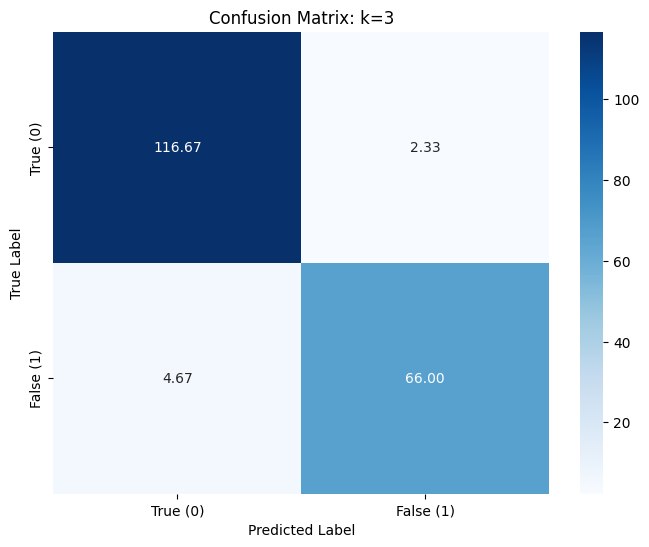

In [29]:
# Fold bazında sonuçları yaz
print("\n --- Results by Fold:")
print("-" * 100)
print(f"{'Fold':<6} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'Run Time':<10}")
print("-" * 100)

for fold_result in results['fold_results']:
    print(f"{fold_result['fold']:<6} {fold_result['accuracy']:.4f} {fold_result['precision']:.4f} {fold_result['recall']:.4f} {fold_result['f1']:.4f} {fold_result['run_time']:.4f}s")

# Modelin sonucu
print("\n--- Results Summary:")
print("-" * 50)
print(f"Configuration: k={k}")
print(f"Average Accuracy: {results['accuracy']:.4f}")
print(f"Average Precision: {results['precision']:.4f}")
print(f"Average Recall: {results['recall']:.4f}")
print(f"Average F1 Score: {results['f1']:.4f}")
print(f"Average Fold Run Time: {results['run_time']:.4f}s")
print(f"Total Run Time: {overall_run_time:.4f}s")

# Grafiği çiz.
plot_confusion_matrix(results['conf_matrices'], f"k={k}")

```markdown
### Analysis of Results

The KNN classifier achieved high performance with an average accuracy of 96.31%, precision of 96.55%, recall of 93.45%, and F1 score of 94.94%. These metrics indicate that the model is effective in distinguishing between the two classes. The confusion matrix shows a low number of misclassifications, and the average runtime per fold is efficient, making the model suitable for this dataset.
```